## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.auto import tqdm
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F
from torchvision.utils import make_grid

## Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/EE5179(DL for imaging)/kaggle/train"
VAL_DIR = "/content/drive/MyDrive/EE5179(DL for imaging)/kaggle/val"

In [ ]:
class rgb2thermal_Dataset(Dataset):
    def __init__(self,
                 base_path,
                 transform=transforms.Compose([transforms.ToTensor()]),
                 isTrain=False):
        self.base_path = base_path
        self.rgb_imgNames = sorted(os.listdir(os.path.join(base_path, "rgb")))
        self.thermal_imgNames = sorted(os.listdir(os.path.join(base_path, "thermal")))

        self.isTrain = isTrain
        self.transform = transform


    def __getitem__(self, idx):
        rgb_imName = self.rgb_imgNames[idx]
        thermal_imName = self.thermal_imgNames[idx]

        rgb = Image.open(os.path.join(self.base_path, "rgb",  rgb_imName))
        thermal = Image.open(os.path.join(self.base_path, "thermal", thermal_imName))

        rgb_tf = self.transform(rgb)
        thermal_tf = self.transform(thermal)

        return {"rgb": rgb_tf, "thermal": thermal_tf, "fileName": rgb_imName}


    def __len__(self):
        return len(self.rgb_imgNames)

### Transforms

In [ ]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

In [ ]:
train_data = rgb2thermal_Dataset(TRAIN_DIR, transform, isTrain=True)
val_data = rgb2thermal_Dataset(VAL_DIR, transform)

## DataLoaders

In [ ]:
trainLoader = DataLoader(train_data, shuffle=True, batch_size=16)
valLoader = DataLoader(val_data, shuffle=False, batch_size=16)

### Sanity Visualizations

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.axis(False)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

**Note: Normalized images always look darker!**    


Try commenting out the normalization transform to see your actual images, as is

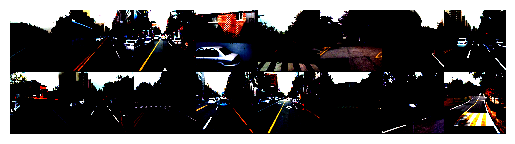

In [ ]:
out = next(iter(trainLoader))
show(torchvision.utils.make_grid(out['rgb'], nrow=8))

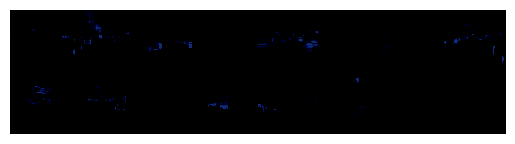

In [ ]:
show(torchvision.utils.make_grid(out['thermal'], nrow=8))

## pix2pix Gan model

In [ ]:
#Discriminator model

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [ ]:
# generator model

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 128
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
EPOCHS = 200
LOAD_MODEL = False
SAVE_MODEL = False

In [ ]:
disc = Discriminator(in_channels=3).to(DEVICE)
gen = model.to(DEVICE)



opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [ ]:

overall_valid_loss = np.inf

for epoch in range(EPOCHS):
    ### Train
    disc.train()
    gen.train()
    train_loss = 0
    loop = tqdm(trainLoader, leave=True)
    for idx, batch in enumerate(loop):

        x = batch['rgb'].to(DEVICE)
        y = batch['thermal'].to(DEVICE)

        #training discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        #training generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )


        train_loss += D_loss.item()
    train_loss /= len(trainLoader)
    print(f"EPOCH: {epoch + 1}, train_loss: {train_loss}")
    if epoch%20 == 0:
      torch.save(gen.state_dict(),'/content/drive/MyDrive/EE5179(DL for imaging)/kaggle/generator.pth' )



  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 1, train_loss: 0.47509373884934647


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 2, train_loss: 0.11996719711101972


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 3, train_loss: 0.11635938473045826


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 4, train_loss: 0.13054706854029344


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 5, train_loss: 0.025696439668536186


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 6, train_loss: 0.0141565982109079


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 7, train_loss: 0.11816663054319529


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 8, train_loss: 0.014067503415907805


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 9, train_loss: 0.009685125631781725


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 10, train_loss: 0.10942432196954122


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 11, train_loss: 0.00807033314441259


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 12, train_loss: 0.005345128824074681


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 13, train_loss: 0.0040394858815349065


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 14, train_loss: 0.0024679290847136426


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 15, train_loss: 0.002012107329658018


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 16, train_loss: 0.0027374174983169023


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 17, train_loss: 0.009655516390473797


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 18, train_loss: 0.0015099698435873366


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 19, train_loss: 0.0018580190622462676


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 20, train_loss: 0.00183295937649046


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 21, train_loss: 0.30423036587352936


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 22, train_loss: 0.021305905912931147


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 23, train_loss: 0.006828445167495654


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 24, train_loss: 0.003778076680520406


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 25, train_loss: 0.20514832997622973


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 26, train_loss: 0.07993960410643082


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 27, train_loss: 0.010377929789515641


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 28, train_loss: 0.006260194217499632


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 29, train_loss: 0.060440041705106314


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 30, train_loss: 0.005007011547254829


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 31, train_loss: 0.00401289696052957


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 32, train_loss: 0.0027503910564029444


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 33, train_loss: 0.0023646800062404228


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 34, train_loss: 0.0014871520366376409


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 35, train_loss: 0.0016881072481807608


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 36, train_loss: 0.001132967667385506


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 37, train_loss: 0.0007014408282255037


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 38, train_loss: 0.0014804750519733017


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 39, train_loss: 0.05336547986819194


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 40, train_loss: 0.0042228526543252745


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 41, train_loss: 0.003866815622537755


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 42, train_loss: 0.001897813434390208


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 43, train_loss: 0.0013887492169697697


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 44, train_loss: 0.0013360803781184726


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 45, train_loss: 0.0017916228958011534


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 46, train_loss: 0.13049897603833904


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 47, train_loss: 0.0070766749935081375


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 48, train_loss: 0.0037994037256934322


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 49, train_loss: 0.002075193620895824


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 50, train_loss: 0.0018756001704157545


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 51, train_loss: 0.0016480198219561806


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 52, train_loss: 0.0013012791562897082


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 53, train_loss: 0.0009304145400304921


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 54, train_loss: 0.0010058751665593052


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 55, train_loss: 0.0006499259065514287


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 56, train_loss: 0.0007222317568868255


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 57, train_loss: 0.000568505152925634


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 58, train_loss: 0.0004408223644042244


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 59, train_loss: 0.0004790181811236275


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 60, train_loss: 0.00040033134170628797


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 61, train_loss: 0.00453648673697339


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 62, train_loss: 0.0003266502209813692


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 63, train_loss: 0.0015189569256528136


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 64, train_loss: 0.2652647467545019


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 65, train_loss: 0.007748141177356816


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 66, train_loss: 0.0031934575679210516


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 67, train_loss: 0.0021496734832628416


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 68, train_loss: 0.0015571131236636294


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 69, train_loss: 0.0011833977540775848


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 70, train_loss: 0.000989468643316426


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 71, train_loss: 0.0008943651278968901


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 72, train_loss: 0.0015702075647333494


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 73, train_loss: 0.0294463854856216


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 74, train_loss: 0.002762860900614984


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 75, train_loss: 0.001078072958625853


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 76, train_loss: 0.0020856220002035395


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 77, train_loss: 0.0025500445958012


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 78, train_loss: 0.0010589859891647043


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 79, train_loss: 0.000705092155168621


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 80, train_loss: 0.0005560084288635362


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 81, train_loss: 0.00045576651889580087


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 82, train_loss: 0.0007300066650854065


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 83, train_loss: 0.0007817377128118936


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 84, train_loss: 0.00041388096511722186


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 85, train_loss: 0.00042507498068376803


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 86, train_loss: 0.00028764485927800144


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 87, train_loss: 0.0006976730771174726


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 88, train_loss: 0.15365012657398788


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 89, train_loss: 0.0035297930563011996


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 90, train_loss: 0.0032706544573347157


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 91, train_loss: 0.0022504883952653753


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 92, train_loss: 0.002243521297798277


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 93, train_loss: 0.003193369876736632


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 94, train_loss: 0.0007447674142895266


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 95, train_loss: 0.0005654064468287218


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 96, train_loss: 0.0005162330881620829


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 97, train_loss: 0.0005138029407065075


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 98, train_loss: 0.00039594106380648627


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 99, train_loss: 0.00037983067808314584


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 100, train_loss: 0.0003452021521157943


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 101, train_loss: 0.00037262986801439325


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 102, train_loss: 0.0038509641897130327


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 103, train_loss: 0.07544998031539413


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 104, train_loss: 0.0023692089034459338


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 105, train_loss: 0.0014022972201928497


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 106, train_loss: 0.0008991548034828156


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 107, train_loss: 0.0009476555594189379


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 108, train_loss: 0.0017326843678557241


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 109, train_loss: 0.003957736080225843


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 110, train_loss: 0.0005978397344453977


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 111, train_loss: 0.0004221360208108448


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 112, train_loss: 0.0003967645895989755


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 113, train_loss: 0.00036141809440988043


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 114, train_loss: 0.0002967936031592007


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 115, train_loss: 0.00027773637378301756


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 116, train_loss: 0.0002506914886628063


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 117, train_loss: 0.00021534727191185364


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 118, train_loss: 0.0001862077865203341


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 119, train_loss: 0.00020531557294396828


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 120, train_loss: 0.00015693958065150164


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 121, train_loss: 0.00015604887415135565


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 122, train_loss: 0.0004505649617035837


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 123, train_loss: 0.00017145216731408324


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 124, train_loss: 0.0025213685968572884


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 125, train_loss: 0.047308617925199754


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 126, train_loss: 0.001263698573725728


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 127, train_loss: 0.0021700392226473644


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 128, train_loss: 0.012712739815469831


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 129, train_loss: 0.0008769655011397285


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 130, train_loss: 0.00046233077390262715


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 131, train_loss: 0.002775944033727193


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 132, train_loss: 0.011022368707255316


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 133, train_loss: 0.0018345594298667632


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 134, train_loss: 0.00034043958518080984


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 135, train_loss: 0.0005837576100020669


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 136, train_loss: 0.00042529409603538136


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 137, train_loss: 0.00018090010663189996


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 138, train_loss: 0.00012460282338836874


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 139, train_loss: 0.00013485995648527304


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 140, train_loss: 0.0003708890311827417


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 141, train_loss: 0.001531059362549478


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 142, train_loss: 0.10969821157184645


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 143, train_loss: 0.0020346216606692627


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 144, train_loss: 0.0008872689612102337


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 145, train_loss: 0.0006650927404944713


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 146, train_loss: 0.0004869809190635211


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 147, train_loss: 0.0004841508482618687


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 148, train_loss: 0.0004014048512684754


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 149, train_loss: 0.0003077502810181333


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 150, train_loss: 0.0013392353422554712


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 151, train_loss: 0.026662062822232165


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 152, train_loss: 0.0010061675136407407


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 153, train_loss: 0.0005722932913788379


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 154, train_loss: 0.0005557148683762465


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 155, train_loss: 0.0003707335482781323


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 156, train_loss: 0.0003375730719059133


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 157, train_loss: 0.00044112379434339415


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 158, train_loss: 0.00030098114903711785


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 159, train_loss: 0.00020216382382876383


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 160, train_loss: 0.00022855864707917834


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 161, train_loss: 0.00019190433046717843


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 162, train_loss: 0.00015104373205059135


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 163, train_loss: 0.00015578471415770204


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 164, train_loss: 0.00012615750462058575


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 165, train_loss: 0.00017633358276305863


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 166, train_loss: 0.00014299291318680982


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 167, train_loss: 0.00011785592231227873


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 168, train_loss: 0.00010906632554766615


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 169, train_loss: 9.026001599312831e-05


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 170, train_loss: 0.004251424520183579


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 171, train_loss: 0.161682678015831


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 172, train_loss: 0.002993671202029173


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 173, train_loss: 0.0013062963580103735


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 174, train_loss: 0.0007782039062406581


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 175, train_loss: 0.0006229104729405103


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 176, train_loss: 0.0006126168595913511


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 177, train_loss: 0.0003870697046155468


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 178, train_loss: 0.0003171134713808827


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 179, train_loss: 0.0002735421252929462


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 180, train_loss: 0.00036450282333624695


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 181, train_loss: 0.00027465431541294


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 182, train_loss: 0.00021258158611509807


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 183, train_loss: 0.00014853512066810465


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 184, train_loss: 0.00025693481685056424


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 185, train_loss: 0.00027693725972382637


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 186, train_loss: 0.00015546623757332922


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 187, train_loss: 0.00018558141001938984


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 188, train_loss: 0.00016507245605820432


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 189, train_loss: 0.00026565464983062924


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 190, train_loss: 0.00011246966278122272


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 191, train_loss: 8.741657497571746e-05


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 192, train_loss: 7.564202493925292e-05


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 193, train_loss: 0.00010205949611890202


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 194, train_loss: 0.00036858072892825405


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 195, train_loss: 0.0026886993148274576


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 196, train_loss: 0.0002971934789876776


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 197, train_loss: 0.00022420312161557375


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 198, train_loss: 0.0001514792485977523


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 199, train_loss: 0.00011545635478306884


  0%|          | 0/65 [00:00<?, ?it/s]

EPOCH: 200, train_loss: 0.00010726026272235545


In [ ]:
torch.save(gen.state_dict(),'/content/drive/MyDrive/EE5179(DL for imaging)/kaggle/generator.pth' )

In [ ]:

def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    model.load_state_dict(torch.load('/content/drive/MyDrive/EE5179(DL for imaging)/kaggle/generator.pth'))
    preds = model(x)
    print(preds.shape)
test()

torch.Size([1, 3, 256, 256])


In [ ]:
model = Generator()
model.load_state_dict(torch.load('/content/drive/MyDrive/EE5179(DL for imaging)/kaggle/generator.pth'))

<All keys matched successfully>

In [ ]:
!mkdir predictions

In [ ]:
def invTrans(img):
    return 255 * img

### Load best saved model >> Validate per Image >> Store in dir

In [ ]:
#ckpts = sorted([x for x in os.listdir(os.getcwd()) if x.endswith(".pth")])
#best_ckpt = ckpts[-1]

model.to(DEVICE)

valLoader2 = DataLoader(val_data, shuffle=False, batch_size=1)

model.eval()
for data in tqdm(valLoader2):
    img, thermal, fName = data['rgb'], data['thermal'], str(data['fileName'][0]).strip()
#     print(fName, len(fName))
    img = img.to(DEVICE)
    thermal = thermal.to(DEVICE)

    outputs = model(img).detach()

    inv_tensor = invTrans(outputs).cpu()
    inv_tensor = F.interpolate(inv_tensor, size=(128, 128), mode='bilinear').numpy()[0].transpose(1,2,0)
    #print(inv_tensor.shape)
    cv2.imwrite(f"/content/predictions/{fName}", inv_tensor)

  0%|          | 0/201 [00:00<?, ?it/s]

### Row Major Encoding (DO NOT CHANGE!)

In [ ]:
# To convert images to Row-Major Format
def row_major_enc(img):
    lst = []
    H,W,C = img.shape
    for i in range(C):
        for j in range(W):
            for k in range(H):
                lst.append(img[k][j][i])
    return lst

### Bim Bim Boom Bam ;)

In [ ]:
# Creating a submission.csv
BASE = "/content/predictions" # wherever you save predictions OR if you have a prediction list use it directly)
val_rgb_lst = os.listdir(BASE)
subDict = {"ID":[], "RMImg": []}

for im_name in tqdm(val_rgb_lst):
    img = cv2.imread(os.path.join(BASE, im_name))
    rme_img = row_major_enc(img)

    subDict["ID"].append(im_name)
    subDict["RMImg"].append(rme_img)

subPd = pd.DataFrame({"ID": [x for x in subDict["ID"]],
                      "RMImg": [x for x in subDict["RMImg"]]})

subPd.to_csv("submission.csv", index=False)

  0%|          | 0/201 [00:00<?, ?it/s]

In [ ]:
!rm -rf predictions/*.jpg *.pth